In [107]:
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

import numpy as np
import pandas as pd
import itertools
import datetime
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn import tree

# You can find the entire Chicago crime data set here: https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2
pd.set_option('display.max_columns', 500)
local_path = r"[Local path of the Chicago historic crime data]"

# Retrieve Historic Crime Data

In [132]:
# read in Chicago crime incident data
chgo_crimes = pd.read_csv(r"{0}\chicago_crimes_2001_2017.csv".format(local_path))
chgo_crimes.drop(chgo_crimes[['X Coordinate','Y Coordinate','Location','Updated On']],inplace=True,axis=1)
chgo_crimes.columns = ['id','case_num','date','block','iucr','primary_type','crime_short_desc',
                      'location_desc','is_arrested','is_domestic','beat','district','ward',
                      'community_area','fbi_code','year','latitude','longitude']
chgo_crimes['district'] = chgo_crimes['district'].fillna(0.0).astype(int)
# remove empty districts
chgo_crimes = chgo_crimes[~chgo_crimes.district.isin([0,13,21,23,31])]
chgo_crimes.head(3)

,id,case_num,date,block,iucr,primary_type,crime_short_desc,location_desc,is_arrested,is_domestic,beat,district,ward,community_area,fbi_code,year,latitude,longitude
0,9716392,HX366301,07/28/2014 07:00:00 PM,050XX N WINTHROP AVE,1320,CRIMINAL DAMAGE,TO VEHICLE,PARKING LOT/GARAGE(NON.RESID.),False,False,2024,20,48.0,3.0,14,2014,41.973924,-87.657752
1,9716393,HX366390,07/30/2014 09:00:00 AM,068XX S KILBOURN AVE,0460,BATTERY,SIMPLE,RESIDENTIAL YARD (FRONT/BACK),False,False,833,8,13.0,65.0,08B,2014,41.769122,-87.734705
2,9716395,HX366298,07/29/2014 08:00:00 PM,003XX E 46TH ST,0910,MOTOR VEHICLE THEFT,AUTOMOBILE,STREET,False,False,215,2,3.0,38.0,07,2014,41.811165,-87.618745


# Feature Engineering

In [109]:
%%time
# Datetime features
chgo_crimes['date'] = pd.to_datetime(chgo_crimes['date'])
chgo_crimes['date_time'] = chgo_crimes['date'].apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day, dt.hour))
chgo_crimes['hour'] = chgo_crimes['date'].dt.hour
chgo_crimes['month'] = chgo_crimes['date'].dt.month
chgo_crimes['year'] = chgo_crimes['date'].dt.year

# Crime description feature
chgo_crimes['crime_desc'] = chgo_crimes[['primary_type', 'crime_short_desc']].apply(lambda x: ' - '.join(x), axis=1)

# Geo features - Allows for a more precise location prediction than "district"
#chgo_crimes['short_lat'], chgo_crimes['short_long'] = chgo_crimes['latitude'], chgo_crimes['longitude']
#chgo_crimes.round({'short_lat':2, 'short_long':2})
#chgo_crimes['short_geo'] = chgo_crimes[['short_lat', 'short_long']].apply(lambda x: ''.join(str(x)), axis=1)
chgo_crimes

Wall time: 25min 41s


# District Crime Score

In [110]:
# Total number of arrests per crime description
chgo_crimes['month'] = chgo_crimes['date'].dt.month
chgo_crimes['year'] = chgo_crimes['date'].dt.year
arrested_desc = chgo_crimes[chgo_crimes['is_arrested']][['id','crime_desc','district','year','month','hour']]
arrested_desc = arrested_desc.groupby(['district','year','month','hour','crime_desc']).id.nunique().reset_index()
arrested_desc.columns = ['district','year','month','hour','crime_desc','arrested_total']

# Total number of incidents (arrest or non-arrest) per crime description
crime_desc = chgo_crimes[['id','crime_desc','district','year','month','hour']]
crime_desc = crime_desc.groupby(['district','year','month','hour','crime_desc']).id.nunique().reset_index()
crime_desc.columns = ['district','year','month','hour','crime_desc','total']

# Calculate score
chgo_district_scores = pd.merge(crime_desc, arrested_desc, how = 'left')
chgo_district_scores.fillna(0, inplace = True)
chgo_district_scores['raw_intensity'] = chgo_district_scores['arrested_total'] / chgo_district_scores['total']
chgo_district_scores['final_intensity'] = chgo_district_scores['arrested_total'] * chgo_district_scores['raw_intensity']

# Summarize score by district, year, month, and hour
chgo_district_scores = chgo_district_scores.groupby(['district','year','month','hour'])[['final_intensity','total','arrested_total']].sum().reset_index()
chgo_district_scores.sort_values('final_intensity', inplace = True)

# Save pickle file for future analysis
chgo_district_scores.to_pickle('district_crime_scores.pkl')

chgo_district_scores.head(5)

,district,year,month,hour,final_intensity,total,arrested_total
68187,16,2010,4,3,0.0,18,0.0
74117,17,2014,8,5,0.0,8,0.0
74118,17,2014,8,6,0.0,8,0.0
30821,7,2010,7,5,0.0,30,0.0
2018,1,2008,1,2,0.0,20,0.0


# Predictive Model

In [111]:
# Partition data for cross-validation
#holdout = chgo_district_scores.sample(frac=0.2)
#training = chgo_district_scores.loc[~chgo_district_scores.index.isin(holdout.index)]

# Decision Tree Regressor for Continuous predictor
dtr = tree.DecisionTreeRegressor()
dtr = dtr.fit(chgo_district_scores[['district','year','month','hour']], chgo_district_scores['final_intensity'])
dtr.predict([[11,2018,4,10]]) 


array([ 25.5])

## Simulate Predictions

In [112]:
# Create cartesian product from all possible predictor variable values
simulation_bounds = {'district':[1,2,3,4,5,6,7,8,9,10,11,12,14,15,16,17,18,19,20,22,24,25],
                     'year':[2018],
                     'month':[1,2,3,4,5,6,7,8,9,10,11,12],
                     'hour':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]}
simulated = pd.DataFrame(list(itertools.product(*simulation_bounds.values())),
                                    columns=simulation_bounds.keys())

In [113]:
# Simulate future predictions for year 2018
simulated_predictions = dtr.predict(simulated[['district','year','month','hour']])
simulated['predicted_crime'] = simulated_predictions
simulated.sort_values(['year', 'month', 'hour', 'predicted_crime'], inplace = True)
simulated.head(22)

,month,district,hour,year,predicted_crime
24,1,2,1,2018,1.000000
432,1,20,1,2018,1.000000
96,1,5,1,2018,1.142857
312,1,15,1,2018,1.666667
0,1,1,1,2018,2.500000
336,1,16,1,2018,2.500000
216,1,10,1,2018,3.000000
264,1,12,1,2018,3.000000
456,1,22,1,2018,3.000000
360,1,17,1,2018,3.200000


# Auditing

## Descriptive Statistics

In [114]:
# Arrest rate by district
arrest_rates = chgo_district_scores.groupby('district')[['total','arrested_total']].sum().reset_index()
arrest_rates['arrest_rate'] = arrest_rates['arrested_total'] / arrest_rates['total']
arrest_rates.head(5)

,district,total,arrested_total,arrest_rate
0,1,233150,71493.0,0.306640
1,2,305493,89606.0,0.293316
2,3,322338,89772.0,0.278503
3,4,358634,84875.0,0.236662
4,5,279458,73970.0,0.264691


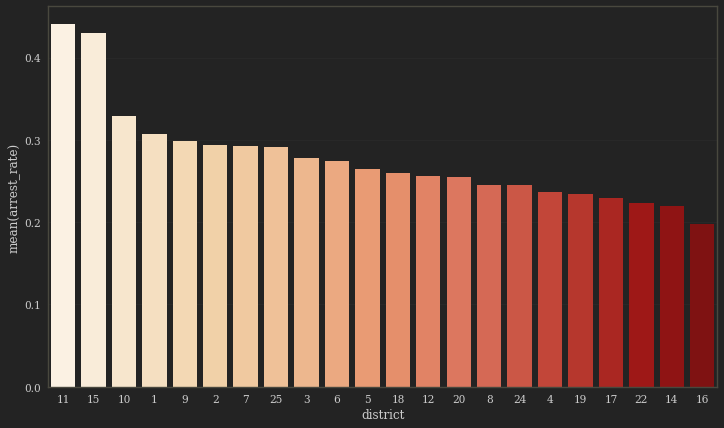

In [115]:
from jupyterthemes import jtplot
jtplot.style()

arrests = arrest_rates[['district','arrest_rate']].sort_values('arrest_rate', ascending=False).reset_index(drop=True)
district_order = arrests['district']
bp = sns.barplot(x='district', y='arrest_rate', data=arrests, order=district_order, palette="OrRd")
bp.figure.set_size_inches(12,7)

In [116]:
# Retrieve demographic data
chgo_stats = pd.read_csv(r"{0}\chicago_zip_demographics.csv".format(local_path))
chgo_stats = chgo_stats.groupby('district')[['white_population','total_population',
                                            'black_population','asian_population',
                                            'hispanic_population','salary']].sum().reset_index()
chgo_stats['total_population'] = (chgo_stats['black_population'] + chgo_stats['asian_population'] + 
                                  chgo_stats['hispanic_population'] + chgo_stats['white_population'])
chgo_stats['proportion_white'] = chgo_stats['white_population'] / chgo_stats['total_population']
chgo_stats['proportion_black'] = chgo_stats['black_population'] / chgo_stats['total_population']
chgo_stats['proportion_asian'] = chgo_stats['asian_population'] / chgo_stats['total_population']
chgo_stats['proportion_hispanic'] = chgo_stats['hispanic_population'] / chgo_stats['total_population']
chgo_stats.head(5)

,district,white_population,black_population,asian_population,hispanic_population,salary,total_population,proportion_white,proportion_black,proportion_asian,proportion_hispanic
0,1,23164.0,5426.0,5822.0,2518.0,736426.0,36930.0,0.627241,0.146927,0.157650,0.068183
1,2,22256.0,65177.0,22182.0,6518.0,141274.0,116133.0,0.191642,0.561227,0.191005,0.056125
2,3,7510.0,117797.0,2071.0,2411.0,91138.0,129789.0,0.057863,0.907604,0.015957,0.018576
3,4,10363.0,49595.0,235.0,35693.0,74615.0,95886.0,0.108076,0.517229,0.002451,0.372244
4,5,1727.0,93850.0,84.0,3310.0,57020.0,98971.0,0.017450,0.948258,0.000849,0.033444


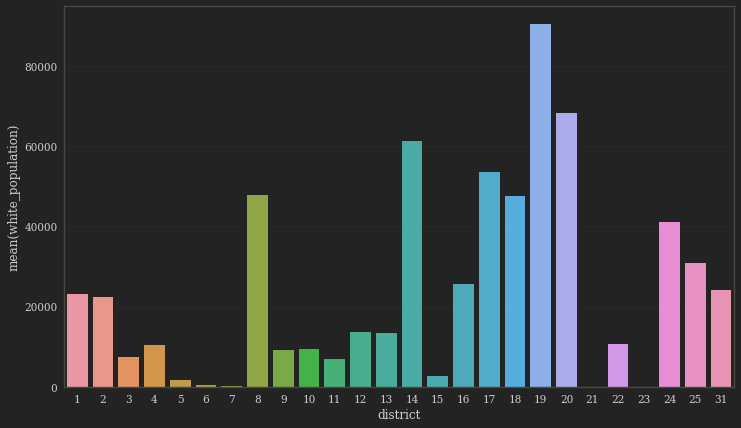

In [117]:
bp = sns.barplot(x='district', y='white_population', data=chgo_stats)
bp.figure.set_size_inches(12,7)

In [118]:
# Retrieve average arrest rate for shared crimes across all districts

# Total number of arrests per crime description
arrested_total = chgo_crimes[chgo_crimes['is_arrested']][['id','crime_desc','district']]
arrested_total = arrested_total.groupby(['district','crime_desc']).id.nunique().reset_index()
arrested_total.columns = ['district','crime_desc','arrested_total']

# Total number of incidents (arrest or non-arrest) per crime description
incidents_total = chgo_crimes[['id','crime_desc','district']]
incidents_total = incidents_total.groupby(['district','crime_desc']).id.nunique().reset_index()
incidents_total.columns = ['district','crime_desc','total']

# Calculate score
district_arrest_rates = pd.merge(incidents_total, arrested_total, how = 'left')
district_arrest_rates.fillna(0, inplace = True)
district_arrest_rates['arrest_rate'] = district_arrest_rates['arrested_total'] / district_arrest_rates['total']

# Test various crime types
district_arrest_rates = district_arrest_rates[district_arrest_rates['crime_desc'] == 'BATTERY - DOMESTIC BATTERY SIMPLE']

# Summarize score
district_arrest_rates = district_arrest_rates.groupby(['district'])[['arrest_rate','total','arrested_total']].mean().reset_index()
district_arrest_rates.head(5)

,district,arrest_rate,total,arrested_total
0,1,0.241785,5691,1376.0
1,2,0.223037,23857,5321.0
2,3,0.237610,32970,7834.0
3,4,0.210695,32839,6919.0
4,5,0.223233,27272,6088.0


In [119]:
# Total all simulated predictions by district and merge with district level stats
district_audit = simulated.groupby('district')[['predicted_crime']].sum().reset_index()
district_audit = pd.merge(district_audit, chgo_stats, on=['district'], how='inner')
district_audit = pd.merge(district_audit, district_arrest_rates, on=['district'], how='inner')
district_audit.head(5)

,district,predicted_crime,white_population,black_population,asian_population,hispanic_population,salary,total_population,proportion_white,proportion_black,proportion_asian,proportion_hispanic,arrest_rate,total,arrested_total
0,1,1540.007351,23164.0,5426.0,5822.0,2518.0,736426.0,36930.0,0.627241,0.146927,0.157650,0.068183,0.241785,5691,1376.0
1,2,1257.831782,22256.0,65177.0,22182.0,6518.0,141274.0,116133.0,0.191642,0.561227,0.191005,0.056125,0.223037,23857,5321.0
2,3,1504.737823,7510.0,117797.0,2071.0,2411.0,91138.0,129789.0,0.057863,0.907604,0.015957,0.018576,0.237610,32970,7834.0
3,4,1856.498898,10363.0,49595.0,235.0,35693.0,74615.0,95886.0,0.108076,0.517229,0.002451,0.372244,0.210695,32839,6919.0
4,5,2222.052778,1727.0,93850.0,84.0,3310.0,57020.0,98971.0,0.017450,0.948258,0.000849,0.033444,0.223233,27272,6088.0


P-values:
Intercept              3.251857e-15
proportion_hispanic    3.504235e-02
dtype: float64


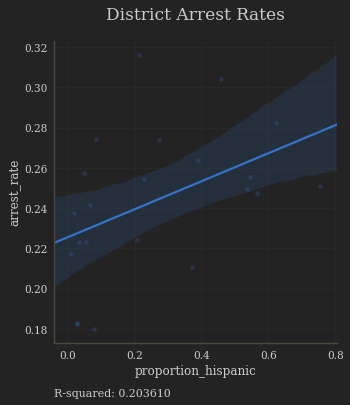

In [120]:
# Run a simple linear regression & print the P values
model = ols("arrest_rate ~ proportion_hispanic", district_audit).fit()
print("P-values:\n%s"%model.pvalues)

# Plot example regression
fig = sns.lmplot(x="proportion_hispanic", y="arrest_rate", data=district_audit, scatter_kws={"s": 20, "alpha": 0.25}, order=1)
plt.rc('font', family='serif', monospace='Courier')
plt.title("District Arrest Rates",  fontsize = 17, y=1.05)
plt.xlabel('proportion_hispanic')
plt.ylabel('arrest_rate')
plt.annotate('R-squared: %f'%(model.rsquared), (0,0), (0,-45),  fontsize = 11, xycoords='axes fraction', textcoords='offset points', va='top')

# As the porportion of Hispanics in each district rises, so does the rate of arrest for the same crimes

## Adjust Predictions for Bias

In [133]:
# Demonstration using the biases against largely hispanic districts shown above
district_audit['pred_bias'] = model.predict()
# Find minimum coefficient as this is the baseline (read "fair") arrest rate
district_audit['min_bias'] = district_audit['pred_bias'].min()
# Calculate difference - output is percentage representing the bias from baseline
district_audit['bias_diff'] = district_audit['pred_bias'] - district_audit['min_bias']
district_bias = district_audit[['district','bias_diff']]
# Join to simulated predictions from demonstrative predictive policing model above
adjusted_predictions = pd.merge(simulated, district_bias, on = ['district'], how = 'left')
adjusted_predictions['adj_predicted_crime'] = adjusted_predictions['predicted_crime'] * adjusted_predictions['bias_diff']
adjusted_predictions['adj_predicted_crime'] = adjusted_predictions['predicted_crime'] - adjusted_predictions['adj_predicted_crime']
adjusted_predictions.sort_values(['year','month','hour','district'], inplace=True)
adjusted_predictions = adjusted_predictions[['year','month','hour','district','predicted_crime','adj_predicted_crime']]
adjusted_predictions.head(22)

,year,month,hour,district,predicted_crime,adj_predicted_crime
4,2018,1,1,1,2.500000,2.489927
0,2018,1,1,2,1.000000,0.996810
15,2018,1,1,3,5.500000,5.496829
21,2018,1,1,4,11.285714,11.001407
2,2018,1,1,5,1.142857,1.141016
20,2018,1,1,6,9.916667,9.916667
16,2018,1,1,7,5.833333,5.826471
13,2018,1,1,8,4.285714,4.126623
18,2018,1,1,9,7.333333,7.064671
6,2018,1,1,10,3.000000,2.844534
